In [1]:
import numpy as np
import pandas as pd
from itertools import groupby
import gc

In [2]:
# Reading dataset
dataset = pd.read_parquet("Zzzs_train.parquet")

In [3]:
# Checking the initial 5 rows of the dataset
dataset.head()

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1


#### Feature engineering

In [4]:
# An array to keep track of all generated features
features = []

We are converting the timestamp column into date time type so that we can extract time related information from the data

In [5]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp']).apply(lambda t: t.tz_localize(None))
# Extracting hour from the timestamp
dataset["hour"] = dataset["timestamp"].dt.hour

In [6]:
def make_features(df):

    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df["hour"] = df["timestamp"].dt.hour
    
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    
    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

In [7]:
df = make_features(dataset)

In [8]:
all_series = df.series_id.unique()
train_series = all_series[:32]
test_series = all_series[32:35]

train_data = df[df['series_id'].isin(train_series)]
test_data = df[df['series_id'].isin(test_series)]

X_train = train_data[features]
y_train = train_data["awake"]
X_test = test_data[features]
y_test = test_data["awake"]

In [9]:
# save some memory
del df
gc.collect();

#### Training Models

#### Random Forest

In [10]:
%%time

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 2h 32min 14s, sys: 50.1 s, total: 2h 33min 4s
Wall time: 39min 20s


RandomForestClassifier(n_jobs=-1)

In [11]:
classifier

RandomForestClassifier(n_jobs=-1)

In [12]:
y_test_pred = classifier.predict(X_test) 

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96    359820
           1       0.98      0.97      0.98    634140

    accuracy                           0.97    993960
   macro avg       0.97      0.97      0.97    993960
weighted avg       0.97      0.97      0.97    993960



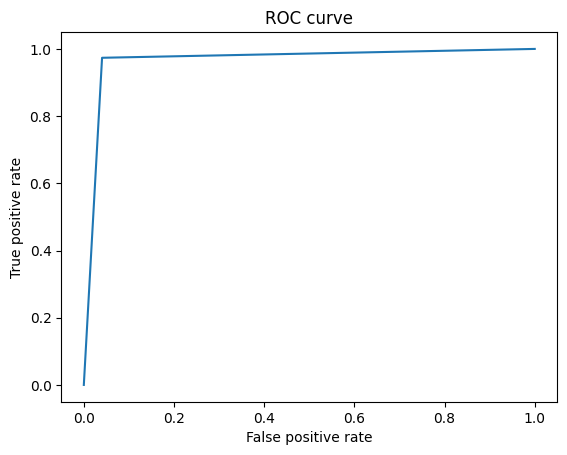

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_test_pred))

0.9665900111881405


In [16]:
from sklearn import metrics

y_test_pred = classifier.predict(X_test) 
metrics.accuracy_score(y_test, y_test_pred) 

0.968533945027969

#### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn import metrics

metrics.accuracy_score(y_test, y_pred) 

0.9196054167169705

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88    359820
           1       0.92      0.96      0.94    634140

    accuracy                           0.92    993960
   macro avg       0.92      0.91      0.91    993960
weighted avg       0.92      0.92      0.92    993960



#### Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train,y_train)

# Prediction on test set
y_pred = model.predict(X_test)

In [21]:
from sklearn import metrics

metrics.accuracy_score(y_test, y_pred) 

0.8243802567507746

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.96      0.80    359820
           1       0.97      0.75      0.84    634140

    accuracy                           0.82    993960
   macro avg       0.83      0.85      0.82    993960
weighted avg       0.87      0.82      0.83    993960



#### XGBoost

In [23]:
import xgboost as xgb

#Creating an XGBoost classifier
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
from sklearn.metrics import accuracy_score, classification_report

#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.9717171717171718

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    359820
           1       0.98      0.97      0.98    634140

    accuracy                           0.97    993960
   macro avg       0.97      0.97      0.97    993960
weighted avg       0.97      0.97      0.97    993960

